# Extracting Data from Bureau of Labor Statistics API Using PySpark

**MOTIVATION:** This is a trite example to show that one could use PySpark to retrieve data from a web API, abeit with a performance penalty due to the creation of the Spark session and converting PySpark dataframe to Pandas dataframe.

In [1]:
from datetime import date
from dateutil.relativedelta import relativedelta
from pathlib import Path
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, concat_ws, to_date
import configparser
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns

The contents of `config.ini` file would look like something similar to below:

```
[bls]
secretkey=some_long_string
```

In [2]:
config = configparser.ConfigParser()
config.read(Path.home() / '.config' / 'config.ini')
bls_key = config['bls']['secretkey']

In [3]:
def create_spark_session():
    """Creates and returns a Spark session (Singleton approach)."""
    return (SparkSession.builder
            .appName("BLS Data Processing")
            .master("local[*]")
            .config("spark.driver.memory", "4g")
            .config("spark.sql.shuffle.partitions", "1")
            .config("spark.sql.execution.arrow.pyspark.enabled", "true")
            .getOrCreate())

In [4]:
def fetch_bls_data(series_id: str, bls_key: str, past_n_years: int = 19):
    """
    Fetches BLS data from API and returns a list of tuples (series_id, year, period, value).
    """
    try:
        current_year = date.today().year
        start_year = current_year - past_n_years

        headers = {"Content-type": "application/json"}
        payload = json.dumps({
            "seriesid": [series_id],
            "startyear": str(start_year),
            "endyear": str(current_year),
            "registrationkey": bls_key,
        })

        response = requests.post(
            "https://api.bls.gov/publicAPI/v2/timeseries/data/",
            data=payload,
            headers=headers,
        )
        response.raise_for_status()

        json_data = response.json()
        series_data = [
            (series["seriesID"], record["year"], record["period"], record["value"])
            for series in json_data["Results"]["series"]
            for record in series["data"]
            if record["period"].startswith("M")  # Filter monthly data
        ]

        return series_data

    except requests.exceptions.RequestException as e:
        print(f"Error fetching BLS data: {e}")
        return []

In [5]:
def plot_bls_series_id(spark, series_id: str, series_descr: str, bls_key: str, past_n_years: int = 19):
    """
    Plots a BLS series using PySpark for data processing.

    Parameters
    ----------
    spark : SparkSession
        Active Spark session.
    series_id : str
        Series ID.
    series_descr : str
        Series description.
    bls_key : str
        BLS API key.
    past_n_years : int, optional
        Number of years of data to plot (default is 19).
    """
    try:
        # Fetch data from BLS API
        series_data = fetch_bls_data(series_id, bls_key, past_n_years)
        if not series_data:
            print("No data available for the given series.")
            return

        # Create Spark DataFrame
        df = spark.createDataFrame(series_data, ["series_id", "year", "period", "value"])

        # Transform DataFrame
        df = (df.filter((col("period") >= "M01") & (col("period") <= "M12"))
              .withColumn("year_month", to_date(concat_ws("-", col("year"), col("period").substr(2, 2)), "yyyy-MM"))
              .withColumn("value", col("value").cast("double"))
              .select("series_id", "year_month", "value")
              .persist())  # Cache the data for potential reuse

        # Convert PySpark DataFrame to Pandas for plotting
        df_final = df.toPandas()

        # Visualization
        fig, ax = plt.subplots(figsize=(8, 5))
        sns.lineplot(data=df_final, x="year_month", y="value", ax=ax)

        # Define shading regions
        current_date = date.today()
        previous_month = (current_date - relativedelta(months=1)).strftime("%Y-%m-01")
        start_of_current_year = f"{current_date.year}-01-01"

        ax.fill_between(
            x=[start_of_current_year, previous_month],
            y1=[df_final["value"].max() + 1] * 2,
            alpha=0.2,
            color="blue",
        )
        ax.set_ylim(df_final["value"].min() - 1, df_final["value"].max() + 1)
        ax.spines[["right", "top"]].set_visible(False)
        plt.xlabel("Year")
        plt.ylabel("Value")
        plt.suptitle(series_descr)
        plt.title("grey=recession / blue=current year", fontsize=10)

        # Add recession shading for past 19 years
        if past_n_years == 19:
            recessions = [("2001-03-01", "2001-11-01"), 
                          ("2007-12-01", "2009-06-01"), 
                          ("2020-02-01", "2020-04-01")]
            for start, end in recessions:
                ax.fill_between(
                    x=[start, end],
                    y1=[df_final["value"].max() + 1] * 2,
                    alpha=0.2,
                    color="gray",
                )

        plt.tight_layout()
        plt.grid(True)
        plt.show()

    except (ValueError, KeyError) as e:
        print(f"Error processing data: {e}")

In [ ]:
# Usage
spark = create_spark_session()

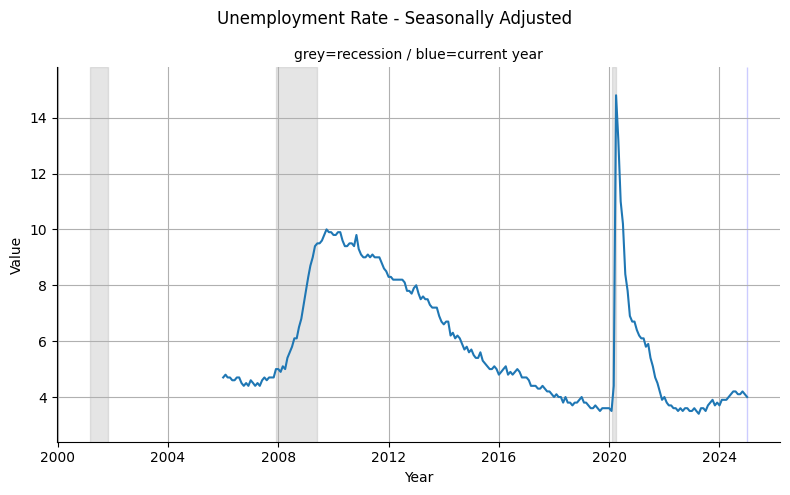

In [7]:
plot_bls_series_id(
    spark=spark,
    series_id='LNS14000000',
    series_descr='Unemployment Rate - Seasonally Adjusted',
    bls_key=bls_key
)

In [8]:
fetch_bls_data("LNS14000000", bls_key, 2)

[('LNS14000000', '2025', 'M01', '4.0'),
 ('LNS14000000', '2024', 'M12', '4.1'),
 ('LNS14000000', '2024', 'M11', '4.2'),
 ('LNS14000000', '2024', 'M10', '4.1'),
 ('LNS14000000', '2024', 'M09', '4.1'),
 ('LNS14000000', '2024', 'M08', '4.2'),
 ('LNS14000000', '2024', 'M07', '4.2'),
 ('LNS14000000', '2024', 'M06', '4.1'),
 ('LNS14000000', '2024', 'M05', '4.0'),
 ('LNS14000000', '2024', 'M04', '3.9'),
 ('LNS14000000', '2024', 'M03', '3.9'),
 ('LNS14000000', '2024', 'M02', '3.9'),
 ('LNS14000000', '2024', 'M01', '3.7'),
 ('LNS14000000', '2023', 'M12', '3.8'),
 ('LNS14000000', '2023', 'M11', '3.7'),
 ('LNS14000000', '2023', 'M10', '3.9'),
 ('LNS14000000', '2023', 'M09', '3.8'),
 ('LNS14000000', '2023', 'M08', '3.7'),
 ('LNS14000000', '2023', 'M07', '3.5'),
 ('LNS14000000', '2023', 'M06', '3.6'),
 ('LNS14000000', '2023', 'M05', '3.6'),
 ('LNS14000000', '2023', 'M04', '3.4'),
 ('LNS14000000', '2023', 'M03', '3.5'),
 ('LNS14000000', '2023', 'M02', '3.6'),
 ('LNS14000000', '2023', 'M01', '3.5')]